# <font color=blue>Machine Learning Capstone</font>
### Student Name: Michael Franklin
### Date: 11/21/2022
### Description:


# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# disable CuDNN (GPU Support)
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# image importing
from PIL import Image

Save and Load Functions for GANs

In [2]:
def save(gan, generator, discriminator):
    discriminator.trainable = False
    tf.saved_model.save(gan, "gan")
    discriminator.trainable = True
    tf.saved_model.save(generator, "generator")
    tf.saved_model.save(discriminator, "discriminator")

def load(custom_gan = None):
    discriminator = tf.saved_model.load("discriminator")
    generator = tf.saved_model.load("generator")
    
    if (custom_gan is None):
        gan = tf.saved_model.load("gan")
    else:
        gan = tf.saved_model.load("gan", custom_objects={"CustomModel": custom_gan})
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

A couple utility functions to plot images:

In [3]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols*4, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, aspect='auto')
        plt.axis("off")

# Load and Setup Dataset

Seeing as my Capstone Project is implementing a GAN, I decided to work on and explore that portion of my Capstone during this project that uses GANs. As such i'll be using the dataset I chose for my Captsone found here: https://www.kaggle.com/datasets/fournierp/captcha-version-2-images

In [4]:
img_folder=r'samples'
# resize all iamges to these dimensions
IMG_WIDTH=50
IMG_HEIGHT=200

# function to import all images
def create_dataset(img_folder):
    
    img_data_array=[]
    class_name=[]
    for file in os.listdir(img_folder):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path= os.path.join(img_folder,  file)
            image= Image.open(image_path).convert('RGB')
            image= image.resize((IMG_HEIGHT,IMG_WIDTH),3)
            arr = np.array(image)
            arr = arr.astype('float32')
            arr /= 255
            img_data_array.append(arr)
            class_name.append(file[:file.index(".")])
    return np.array(img_data_array) , class_name

img_data, class_name=create_dataset(img_folder)

In [5]:
img_data.shape

(1070, 50, 200, 3)

In [6]:
# get all the pokemon names and assing and numaric value to each
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_val=  np.array([target_dict[class_name[i]] for i in range(len(class_name))])
target_labels= np.array(list(target_dict.keys()))
num_classes = len(target_dict)
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)
print(num_classes)
target_dict

1070


{'226md': 0,
 '22d5n': 1,
 '2356g': 2,
 '23mdg': 3,
 '23n88': 4,
 '243mm': 5,
 '244e2': 6,
 '245y5': 7,
 '24f6w': 8,
 '24pew': 9,
 '25257': 10,
 '253dc': 11,
 '25egp': 12,
 '25m6p': 13,
 '25p2m': 14,
 '25w53': 15,
 '264m5': 16,
 '268g2': 17,
 '28348': 18,
 '28x47': 19,
 '2b827': 20,
 '2bg48': 21,
 '2cegf': 22,
 '2cg58': 23,
 '2cgyx': 24,
 '2en7g': 25,
 '2enf4': 26,
 '2fxgd': 27,
 '2g783': 28,
 '2g7nm': 29,
 '2gyb6': 30,
 '2mg87': 31,
 '2mpnn': 32,
 '2n73f': 33,
 '2nbc5': 34,
 '2nbcx': 35,
 '2nf26': 36,
 '2npg6': 37,
 '2nx38': 38,
 '2p2y8': 39,
 '2pfpn': 40,
 '2w4y7': 41,
 '2wc38': 42,
 '2wx73': 43,
 '2x7bm': 44,
 '2xc2n': 45,
 '2ycn8': 46,
 '2yggg': 47,
 '325fb': 48,
 '32cnn': 49,
 '32dnn': 50,
 '33b22': 51,
 '33f7m': 52,
 '33n73': 53,
 '33ng4': 54,
 '33p4e': 55,
 '34b84': 56,
 '34fxm': 57,
 '34pcn': 58,
 '368y5': 59,
 '36bc2': 60,
 '36nx4': 61,
 '36w25': 62,
 '373gb': 63,
 '377xx': 64,
 '378e5': 65,
 '37d52': 66,
 '37ep6': 67,
 '387g2': 68,
 '38n57': 69,
 '3b4we': 70,
 '3bd8f': 71,
 '

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
np.random.seed(42)

# split the data into testing and training data
X_train = img_data
y_train = target_val
#X_train_full, X_test, y_train_full, y_test = train_test_split(img_data,target_val, train_size=0.8)
# split the training data into training and validation data
#X_valid, X_train, y_valid, y_train = train_test_split(X_train_full,y_train_full, train_size=0.7)

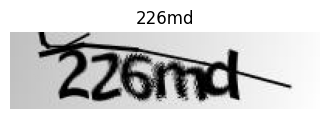

In [9]:
plt.figure(figsize=(4,1))
plt.imshow(X_train[0], aspect='auto')
plt.axis('off')
plt.title(target_labels[y_train[0]], fontsize=12)
plt.show()

In [10]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Image Classifier

In [11]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=5, activation="relu"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(64, kernel_size=5, activation="relu"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

epochs = 15
print(X_train.shape)
print(y_train.shape)
print(input_shape)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

(1070, 50, 200, 3)
(1070,)
(50, 200, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 196, 32)       2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 98, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 94, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 47, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 27072)             0         
                                                                 
 dropout (Dropou

In [12]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/15
17/17 [==============================] - 1s 36ms/step - loss: 7.0570 - accuracy: 0.0000e+00
Epoch 2/15
17/17 [==============================] - 0s 28ms/step - loss: 6.9776 - accuracy: 0.0028
Epoch 3/15
17/17 [==============================] - 0s 28ms/step - loss: 6.9628 - accuracy: 0.0121
Epoch 4/15
17/17 [==============================] - 0s 29ms/step - loss: 6.7955 - accuracy: 0.0178
Epoch 5/15
17/17 [==============================] - 0s 27ms/step - loss: 5.9421 - accuracy: 0.0991
Epoch 6/15
17/17 [==============================] - 0s 27ms/step - loss: 2.3814 - accuracy: 0.5393
Epoch 7/15
17/17 [==============================] - 0s 29ms/step - loss: 0.3191 - accuracy: 0.9084
Epoch 8/15
17/17 [==============================] - 1s 32ms/step - loss: 0.1490 - accuracy: 0.9607
Epoch 9/15
17/17 [==============================] - 1s 30ms/step - loss: 0.0681 - accuracy: 0.9776
Epoch 10/15
17/17 [==============================] - 1s 31ms/step - loss: 0.0841 - accuracy: 0.9804
Epoch

# Tunable GAN Class

In [13]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, codings_size):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.codings_size = codings_size
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    def get_config(self):
        return {"hidden_units": self.hidden_units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)
        
    @property
    def metrics(self):        
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):

        batch_size = real_images.shape[0]

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.codings_size))
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
          [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(labels.shape)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.codings_size))
        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


# HyperGAN Class

In [14]:
from numpy import log, mean, std, floor, exp, expand_dims
import keras_tuner as kt

class HyperGAN(kt.HyperModel):

    def __init__(self, class_model):
        super(HyperGAN, self).__init__()
        self.class_model = class_model

    # Build discriminator function
    def make_discriminator_model(self, hp_drop_rate):
        model = tf.keras.Sequential()
        model.add(keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='SAME',
                                        input_shape=input_shape))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Dropout(hp_drop_rate))

        model.add(keras.layers.Conv2D(128, kernel_size=5, strides=5, padding='SAME'))
        model.add(keras.layers.LeakyReLU())
        model.add(keras.layers.Dropout(hp_drop_rate))

        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(1))

        return model

    # Build generator
    def make_generator_model(self, codings_size, batch_norm, activation_function):
        model = tf.keras.Sequential()
        model.add(keras.layers.Dense(5*20*256, use_bias=False, input_shape=[codings_size]))
        if batch_norm == True:
            model.add(keras.layers.BatchNormalization())
        model.add(activation_function)
        model.add(keras.layers.Reshape((5, 20, 256)))

        model.add(keras.layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='SAME'))
        if batch_norm == True:
            model.add(keras.layers.BatchNormalization())

        model.add(activation_function)

        model.add(keras.layers.Conv2DTranspose(64, kernel_size=5, strides=5, padding='SAME'))
        if batch_norm == True:
            model.add(keras.layers.BatchNormalization())

        model.add(activation_function)

        model.add(keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='SAME',  activation='tanh'))

        return model 
    
    def build(self, hp):

        #hp_codings_size = 100
        #hp_codings_size = hp.Int('codings_size', min_value = 0, max_value = 1000, step = 20)
        hp_codings_size = 380
        #hp_drop_rate = hp.Float('dropout rate', min_value = 0, max_value = 0.9)
        hp_drop_rate = 0.5
        #batch_norm = hp.Boolean('batch normalization')
        batch_norm = False
        #hp_optimizer = hp.Choice('optimizer', ['Nadam',"RMSprop",'Adam'])
        hp_optimizer = "RMSprop"
        #activation_function = hp.Choice('activation function', ['relu', 'leaky_relu'])
        activation_function = 'leaky_relu'
        '''hp_learning_rate = hp.Choice("learning_rate",[
                      0.0001,0.001,0.01,0.1,
                      0.0002,0.002,0.02,0.2,
                      0.0003,0.003,0.03,0.3,
                      0.0004,0.004,0.04,0.4,
                      0.0005,0.005,0.05,0.5,
                      0.0006,0.006,0.06,0.6,
                      0.0007,0.007,0.07,0.7,
                      0.0008,0.008,0.08,0.8,
                      0.0009,0.009,0.09,0.9])'''
        hp_learning_rate= 0.0006
        
        activation_dict = {
            'leaky_relu': keras.layers.LeakyReLU(), 
            'relu': keras.layers.ReLU()
        }

        self.discriminator = self.make_discriminator_model(hp_drop_rate)
        self.generator = self.make_generator_model(hp_codings_size, batch_norm, activation_dict[activation_function])
        model_gan = GAN(self.discriminator, self.generator, hp_codings_size)

        optimizer_dict = {
            'Nadam': tf.keras.optimizers.Nadam(hp_learning_rate), 
            'Adam': tf.keras.optimizers.Adam(hp_learning_rate),
            'RMSprop': tf.keras.optimizers.RMSprop(hp_learning_rate)
        }
        
        optimizer = optimizer_dict[hp_optimizer]
        binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        model_gan.compile(optimizer,optimizer,binary_crossentropy)
        return model_gan
    
    def calculate_score(self, images, n_split=10, eps=10**-16):
        # load classification model
        model = self.class_model
        # predict class probabilities for images
        yhat = model.predict(images)
        # enumerate splits of images/predictions
        scores = list()
        n_part = floor(images.shape[0] / n_split)

        for i in range(n_split):
            # retrieve p(y|x)
            ix_start, ix_end = int(i * n_part), int(i * n_part + n_part)
            p_yx = yhat[ix_start:ix_end]
            # calculate p(y)
            p_y = expand_dims(p_yx.mean(axis=0), 0)
            # calculate KL divergence using log probabilities
            kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
            # sum over classes
            sum_kl_d = kl_d.sum(axis=1)
            # average over images
            avg_kl_d = mean(sum_kl_d)
            # undo the log
            is_score = exp(avg_kl_d)
            # store
            scores.append(is_score)

        # average across images
        is_avg, is_std = mean(scores), std(scores)

        return is_avg, is_std

    def fit(self, hp, model, x, **kwargs):
        model.fit(x,**kwargs)

        random_latent_vectors = tf.random.normal(shape=(500, model.codings_size))

        generated_images = model.generator.predict(random_latent_vectors)

        mean_score, std_score = self.calculate_score(generated_images)
        
        return -mean_score

# Running the Keras Tuner

In [16]:
tuner = kt.BayesianOptimization(
    hypermodel=HyperGAN(model),
    # No objective to specify.
    # Objective is the return value of `HyperModel.fit()`.
    #max_epochs=500,
    #hyperband_iterations=5,
     max_trials=1000,
    directory="tuning_dir",
    project_name="dropout_bn_activation_tuning",
)

'''tuner.search(
    x = dataset,
    epochs = 100
    )

tuner.results_summary()'''

'tuner.search(\n    x = dataset,\n    epochs = 100\n    )\n\ntuner.results_summary()'

This ran about 6 seperate times checking for various individaul hyper parameters, that took about a 25 hours total. This final fine tuning ran for about 45 hours total over the course of a few starts and stops, had to stop it as the deadline was getting too close.

# Retrieving the Best Models

After doing all these runs and getting many neat outputs, I have now found the "best" model setup for these images. I'll just make some build functions outside of the HyperGAN class to allow for easy building without tuning

In [17]:
 # Build discriminator function
def make_discriminator_model(hp_drop_rate):
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='SAME',
                                    input_shape=input_shape))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(hp_drop_rate))

    model.add(keras.layers.Conv2D(128, kernel_size=5, strides=5, padding='SAME'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(hp_drop_rate))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

# Build generator
def make_generator_model(codings_size, batch_norm, activation_function):
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(5*20*256, use_bias=False, input_shape=[codings_size]))
    if batch_norm == True:
        model.add(keras.layers.BatchNormalization())
    model.add(activation_function)
    model.add(keras.layers.Reshape((5, 20, 256)))

    model.add(keras.layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='SAME'))
    if batch_norm == True:
        model.add(keras.layers.BatchNormalization())

    model.add(activation_function)

    model.add(keras.layers.Conv2DTranspose(64, kernel_size=5, strides=5, padding='SAME'))
    if batch_norm == True:
        model.add(keras.layers.BatchNormalization())

    model.add(activation_function)

    model.add(keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='SAME',  activation='tanh'))

    return model 

def buildGAN():
    hp_codings_size = 380
    hp_drop_rate = 0.5
    batch_norm = False
    hp_optimizer = "RMSprop"
    activation_function = 'leaky_relu'
    hp_learning_rate= 0.0006

    activation_dict = {
        'leaky_relu': keras.layers.LeakyReLU(), 
        'relu': keras.layers.ReLU()
    }

    discriminator = make_discriminator_model(hp_drop_rate)
    generator = make_generator_model(hp_codings_size, batch_norm, activation_dict[activation_function])
    model_gan = GAN(discriminator, generator, hp_codings_size)

    optimizer_dict = {
        'Nadam': tf.keras.optimizers.Nadam(hp_learning_rate), 
        'Adam': tf.keras.optimizers.Adam(hp_learning_rate),
        'RMSprop': tf.keras.optimizers.RMSprop(hp_learning_rate)
    }

    optimizer = optimizer_dict[hp_optimizer]
    binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model_gan.compile(optimizer,optimizer,binary_crossentropy)
    return model_gan

In [ ]:
#best_model = tuner.get_best_models()[0]

In [ ]:
#random_latent_vectors = tf.random.normal(shape=(20, best_model.codings_size))

#generated_images = best_model.generator.predict(random_latent_vectors)
#plt.figure(figsize = (10, 6), dpi = 80)
#print("Some Input Images:")
#plot_multiple_images(X_train[:20], 4) 
#plt.show()
#print("Generated Images:")
#plot_multiple_images(generated_images, 4) 
#plt.show()

In [19]:
checkpoint_filepath = './model_checkpoints/gan_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq=20
)

In [20]:
#best_hp = tuner.get_best_hyperparameters(1)
'''for i in range(1):
    best_hyperGAN = HyperGAN(model)
    best_gan = best_hyperGAN.build(best_hp[i])
    best_gan.built = True
    if (os.path.exists(checkpoint_filepath)):
        best_gan.load_weights(checkpoint_filepath)
    best_gan.fit(dataset, epochs=500, callbacks=[model_checkpoint_callback])'''
best_gan = buildGAN()
best_gan.built = True
if (os.path.exists(checkpoint_filepath)):
    best_gan.load_weights(checkpoint_filepath)
best_gan.fit(dataset, epochs=500, callbacks=[model_checkpoint_callback])

Epoch 1/500
16/16 [==============================] - 4s 208ms/step - g_loss: 0.7286 - d_loss: 0.6254
Epoch 2/500
16/16 [==============================] - 3s 214ms/step - g_loss: 0.6986 - d_loss: 0.6641
Epoch 3/500
16/16 [==============================] - 3s 215ms/step - g_loss: 1.0685 - d_loss: 0.4916
Epoch 4/500
16/16 [==============================] - 3s 217ms/step - g_loss: 1.3133 - d_loss: 0.4697
Epoch 5/500
16/16 [==============================] - 3s 214ms/step - g_loss: 1.3688 - d_loss: 0.5374
Epoch 6/500
16/16 [==============================] - 3s 209ms/step - g_loss: 1.8191 - d_loss: 0.5798
Epoch 7/500
16/16 [==============================] - 3s 219ms/step - g_loss: 1.3070 - d_loss: 0.5881
Epoch 8/500
16/16 [==============================] - 4s 220ms/step - g_loss: 1.1979 - d_loss: 0.5837
Epoch 9/500
16/16 [==============================] - 3s 216ms/step - g_loss: 1.2477 - d_loss: 0.5826
Epoch 10/500
16/16 [==============================] - 3s 217ms/step - g_loss: 1.1226 - d_lo

16/16 [==============================] - 3s 212ms/step - g_loss: 1.6607 - d_loss: 0.5398
Epoch 82/500
16/16 [==============================] - 3s 217ms/step - g_loss: 1.4617 - d_loss: 0.6098
Epoch 83/500
16/16 [==============================] - 4s 220ms/step - g_loss: 1.5848 - d_loss: 0.4513
Epoch 84/500
16/16 [==============================] - 4s 223ms/step - g_loss: 1.4918 - d_loss: 0.5191
Epoch 85/500
16/16 [==============================] - 4s 221ms/step - g_loss: 1.4306 - d_loss: 0.4976
Epoch 86/500
16/16 [==============================] - 3s 212ms/step - g_loss: 1.7284 - d_loss: 0.5566
Epoch 87/500
16/16 [==============================] - 4s 220ms/step - g_loss: 1.7164 - d_loss: 0.4745
Epoch 88/500
16/16 [==============================] - 4s 220ms/step - g_loss: 1.6745 - d_loss: 0.5200
Epoch 89/500
16/16 [==============================] - 4s 219ms/step - g_loss: 1.6237 - d_loss: 0.4989
Epoch 90/500
16/16 [==============================] - 3s 217ms/step - g_loss: 1.6224 - d_loss: 

16/16 [==============================] - 4s 223ms/step - g_loss: 2.3814 - d_loss: 0.2635
Epoch 161/500
16/16 [==============================] - 3s 214ms/step - g_loss: 3.2853 - d_loss: 0.8640
Epoch 162/500
16/16 [==============================] - 4s 223ms/step - g_loss: 2.8013 - d_loss: 0.4966
Epoch 163/500
16/16 [==============================] - 4s 220ms/step - g_loss: 2.6402 - d_loss: 0.2802
Epoch 164/500
16/16 [==============================] - 4s 220ms/step - g_loss: 2.3894 - d_loss: 0.2202
Epoch 165/500
16/16 [==============================] - 4s 221ms/step - g_loss: 2.2946 - d_loss: 0.6095
Epoch 166/500
16/16 [==============================] - 3s 215ms/step - g_loss: 2.8974 - d_loss: 0.3731
Epoch 167/500
16/16 [==============================] - 4s 223ms/step - g_loss: 2.3405 - d_loss: 0.2491
Epoch 168/500
16/16 [==============================] - 3s 218ms/step - g_loss: 2.2704 - d_loss: 0.7791
Epoch 169/500
16/16 [==============================] - 4s 223ms/step - g_loss: 3.0487 -

16/16 [==============================] - 4s 221ms/step - g_loss: 3.5333 - d_loss: 0.1203
Epoch 240/500
16/16 [==============================] - 4s 222ms/step - g_loss: 2.5704 - d_loss: 0.7351
Epoch 241/500
16/16 [==============================] - 3s 215ms/step - g_loss: 3.5961 - d_loss: 0.0871
Epoch 242/500
16/16 [==============================] - 4s 222ms/step - g_loss: 2.6728 - d_loss: 1.2252
Epoch 243/500
16/16 [==============================] - 4s 220ms/step - g_loss: 3.2665 - d_loss: 0.3978
Epoch 244/500
16/16 [==============================] - 4s 221ms/step - g_loss: 3.2655 - d_loss: 0.2402
Epoch 245/500
16/16 [==============================] - 4s 221ms/step - g_loss: 2.7446 - d_loss: 0.1832
Epoch 246/500
16/16 [==============================] - 3s 216ms/step - g_loss: 2.8658 - d_loss: 0.7396
Epoch 247/500
16/16 [==============================] - 4s 221ms/step - g_loss: 3.5523 - d_loss: 0.2744
Epoch 248/500
16/16 [==============================] - 4s 221ms/step - g_loss: 2.7290 -

16/16 [==============================] - 4s 222ms/step - g_loss: 3.7240 - d_loss: 0.1214
Epoch 319/500
16/16 [==============================] - 4s 221ms/step - g_loss: 4.4810 - d_loss: 0.6705
Epoch 320/500
16/16 [==============================] - 4s 223ms/step - g_loss: 4.1391 - d_loss: 0.4138
Epoch 321/500
16/16 [==============================] - 3s 215ms/step - g_loss: 3.3099 - d_loss: 0.1625
Epoch 322/500
16/16 [==============================] - 4s 221ms/step - g_loss: 3.9672 - d_loss: 0.6192
Epoch 323/500
16/16 [==============================] - 4s 222ms/step - g_loss: 3.9006 - d_loss: 0.3546
Epoch 324/500
16/16 [==============================] - 4s 221ms/step - g_loss: 3.7807 - d_loss: 0.1970
Epoch 325/500
16/16 [==============================] - 4s 221ms/step - g_loss: 3.2446 - d_loss: 0.1537
Epoch 326/500
16/16 [==============================] - 3s 217ms/step - g_loss: 4.3171 - d_loss: 0.7553
Epoch 327/500
16/16 [==============================] - 4s 222ms/step - g_loss: 3.7307 -

16/16 [==============================] - 4s 220ms/step - g_loss: 4.0437 - d_loss: 0.4095
Epoch 398/500
16/16 [==============================] - 4s 221ms/step - g_loss: 3.9756 - d_loss: 0.0772
Epoch 399/500
16/16 [==============================] - 4s 220ms/step - g_loss: 4.0689 - d_loss: 1.3940
Epoch 400/500
16/16 [==============================] - 4s 223ms/step - g_loss: 4.3315 - d_loss: 0.4511
Epoch 401/500
16/16 [==============================] - 3s 214ms/step - g_loss: 3.4463 - d_loss: 0.1855
Epoch 402/500
16/16 [==============================] - 4s 220ms/step - g_loss: 3.1754 - d_loss: 0.3241
Epoch 403/500
16/16 [==============================] - 4s 221ms/step - g_loss: 4.5179 - d_loss: 0.4903
Epoch 404/500
16/16 [==============================] - 4s 222ms/step - g_loss: 3.7340 - d_loss: 0.0705
Epoch 405/500
16/16 [==============================] - 4s 224ms/step - g_loss: 4.6882 - d_loss: 0.8536
Epoch 406/500
16/16 [==============================] - 3s 216ms/step - g_loss: 3.8285 -

16/16 [==============================] - 3s 215ms/step - g_loss: 5.7413 - d_loss: 1.0383
Epoch 477/500
16/16 [==============================] - 4s 224ms/step - g_loss: 4.0113 - d_loss: 0.1031
Epoch 478/500
16/16 [==============================] - 4s 224ms/step - g_loss: 4.1470 - d_loss: 0.5955
Epoch 479/500
16/16 [==============================] - 4s 220ms/step - g_loss: 4.3616 - d_loss: 0.3000
Epoch 480/500
16/16 [==============================] - 4s 219ms/step - g_loss: 3.7517 - d_loss: 0.1279
Epoch 481/500
16/16 [==============================] - 3s 213ms/step - g_loss: 4.3057 - d_loss: 0.9326
Epoch 482/500
16/16 [==============================] - 4s 221ms/step - g_loss: 4.1415 - d_loss: 0.2784
Epoch 483/500
16/16 [==============================] - 4s 219ms/step - g_loss: 3.6556 - d_loss: 0.1071
Epoch 484/500
16/16 [==============================] - 4s 223ms/step - g_loss: 5.3647 - d_loss: 0.8409
Epoch 485/500
16/16 [==============================] - 4s 221ms/step - g_loss: 4.3483 -

1/1 [==============================] - 0s 127ms/step
Some Input Images:


<Figure size 800x480 with 0 Axes>

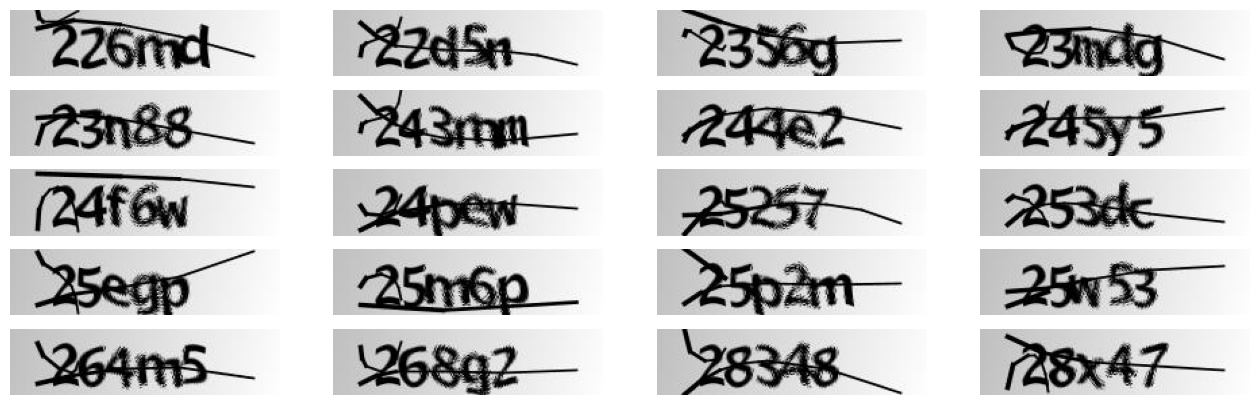

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Generated Images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


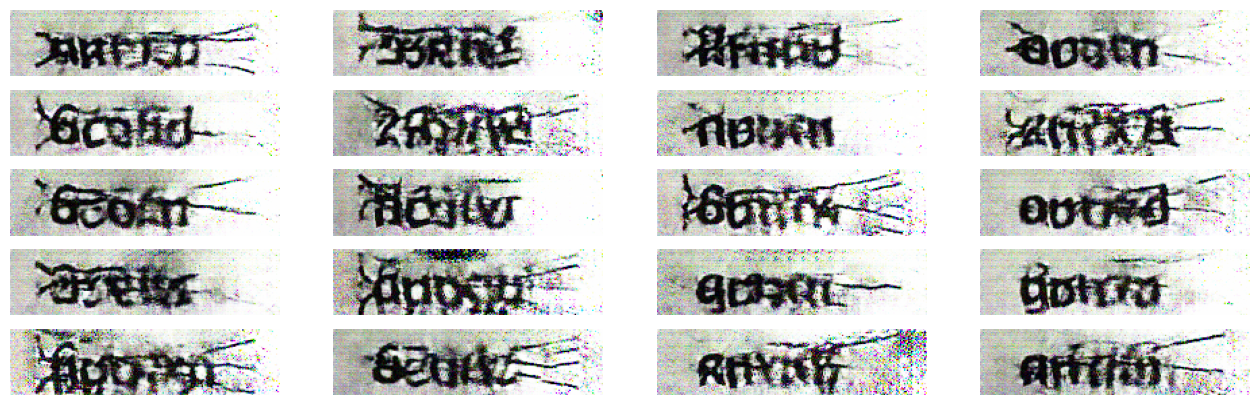

In [21]:
random_latent_vectors = tf.random.normal(shape=(20, best_gan.codings_size))

generated_images = best_gan.generator.predict(random_latent_vectors)
plt.figure(figsize = (10, 6), dpi = 80)
print("Some Input Images:")
plot_multiple_images(X_train[:20], 4) 
plt.show()
print("Generated Images:")
plot_multiple_images(generated_images, 4) 
plt.show()

Well they aren't perfect, seems they would take more tuning or maybe a different model archecture the get anything better out of them. But there is proof of the GAN really picking up patterns from the input so I would call this a sucess.